In [1]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
pd.options.display.max_rows = 100
pd.options.display.max_columns = 40
import numpy as np
import os,random, math
from tqdm import tqdm
from copy import deepcopy
from collections import Counter

# Visualization
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import font_manager, rc
plt.rcParams['font.family'] = 'NanumGothic'
import platform
if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)
else:    
    rc('font', family='AppleGothic')

matplotlib.rcParams['axes.unicode_minus'] = False

# from dataprep.eda import plot, plot_correlation, plot_missing

# Warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
path = os.path.dirname(os.getcwd())
path = os.path.join(path, "ProcessedData")

In [3]:
train = pd.read_csv(os.path.join(path,"merged_train.csv"))
test = pd.read_csv(os.path.join(path,"merged_test.csv"))

In [4]:
def read_file(filename):
    df = pd.read_csv(f'{filename}')
    if sum(df.duplicated(df.columns)) != 0:
        print(f"...There are {sum(df.duplicated(df.columns))} duplicates\n...Remove them")
        df = df.drop_duplicates()
    else:
        print("...There are no duplicates")
    df.name = filename
    print(f"shape: {df.shape}")
    return df

def check_NA(df):
    print(f"NA check")
    NA_res = df.isna().sum()
    if NA_res.sum() != 0:
        for idx, i in enumerate(NA_res):
            if i != 0:
                print(df.columns[idx],i,"->",round(i/df.shape[0]*100,3),"%")
    else:
        print("...There's no NA")

def get_values(data, code, col):
    df = data[(data['단지코드']==code)&(data[col].isna()==False)]
    return df[col].values.mean()

def impute_by_code(data, col, verbose=True):
    code = data[data[col].isna()==True]['단지코드'].unique()
    if verbose == True:
        print(f"{col}에 NA가 있는 단지코드: {code}")
        print(f"{col}이(가) 모두 NA인 단지코드:")
    for i in code:
        n = data[(data['단지코드']==i)&(data[col].isna()==False)].shape[0]
        ind = data[(data['단지코드']==i)&(data[col].isna()==True)].index
        if n != 0 :
            data.loc[ind,col] = get_values(data, i, col)
        if n==0 and verbose == True:
            print(i)
    return data    

def mapping_by_key(dic, x):
    for i in dic.keys():
        if x in dic[i]:
            return int(i)

def make_dummies(data, col):
    sample = pd.DataFrame(data.groupby('단지코드')[col].unique()).reset_index()
    for i in dic.keys():
        data[col.split('_')[0]+str(i)]=0
    for i in sample.index:
        code = sample.loc[i,'단지코드']
        val = sample.loc[i,col]
        ind = data[data['단지코드']==code].index
        for j in val:
            data.loc[ind,col.split('_')[0]+str(j)] = 1
    return data

def dual_countplot(col, train, test, figsize=(14,8), pallete="Set2", flip=True):
    plt.rcParams["figure.figsize"] = figsize
    fig, ax = plt.subplots(ncols=2)
    if flip:
        sns.countplot(y=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(y=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    else:
        sns.countplot(x=train[col],palette=pallete,order=sorted(train[col].unique()),ax=ax[0]).set_title("train")
        sns.countplot(x=test[col],palette=pallete,order=sorted(test[col].unique()),ax=ax[1]).set_title("test")
    plt.tight_layout()
    plt.show()
    
def get_outlier(df=None, column=None, weight=1.5):
  # target 값과 상관관계가 높은 열을 우선적으로 진행
    quantile_25 = np.percentile(df[column].values, 25)
    quantile_75 = np.percentile(df[column].values, 75)

    IQR = quantile_75 - quantile_25
    IQR_weight = IQR*weight
  
    lowest = quantile_25 - IQR_weight
    highest = quantile_75 + IQR_weight
  
    outlier_idx = df[column][ (df[column] < lowest) | (df[column] > highest) ].index
    return outlier_idx

## 자격유형

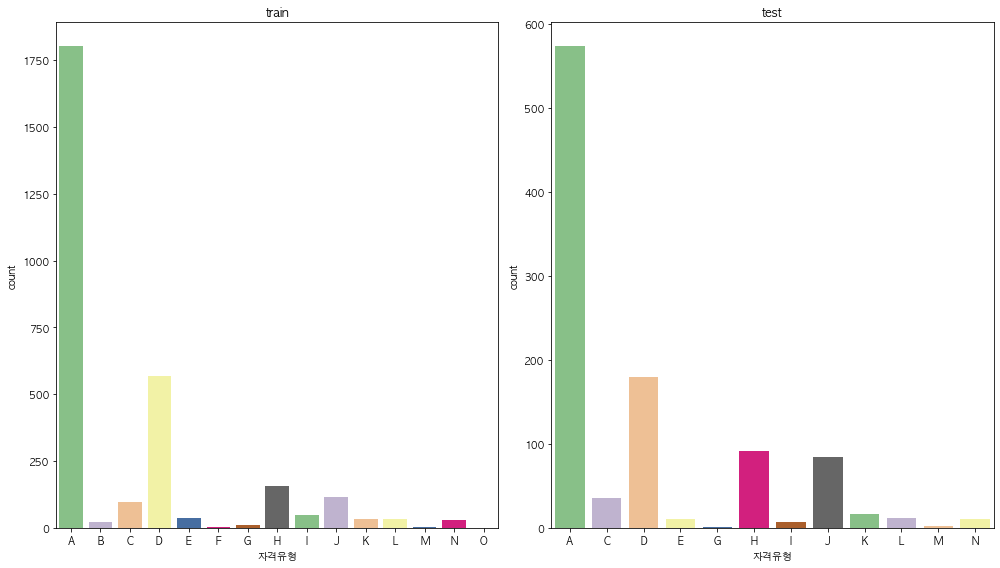

In [5]:
dual_countplot(col="자격유형", train=train, test=test, flip=False, pallete="Accent")

In [6]:
outlier_idx1 = get_outlier(train,'임대보증금')
tmp = train.drop(outlier_idx1,axis=0)
outlier_idx2 = get_outlier(tmp,'임대료')
tmp = tmp.drop(outlier_idx2,axis=0)
outlier_idx3 = get_outlier(tmp,'등록차량수')
tmp = tmp.drop(outlier_idx3,axis=0)

<AxesSubplot:title={'center':'등록차량수/총세대수'}, xlabel='[자격유형]'>

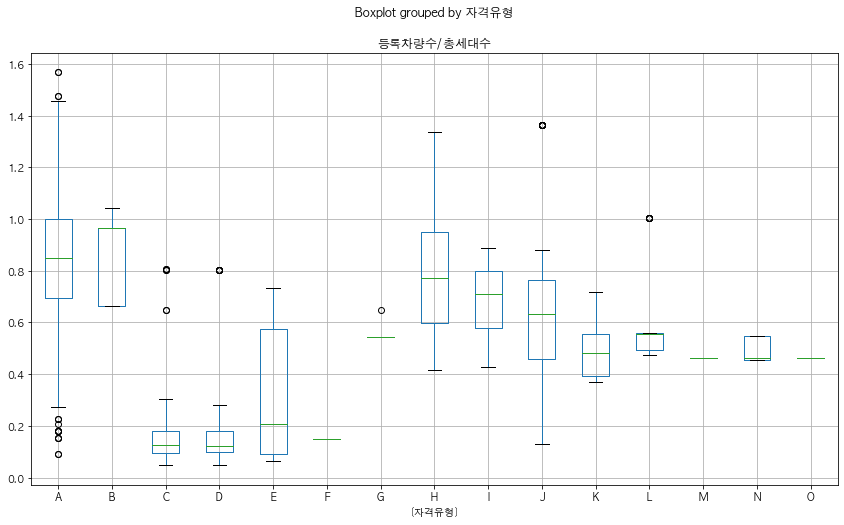

In [7]:
tmp['등록차량수/총세대수'] = tmp.apply(lambda x : x['등록차량수']/x['총세대수'], axis=1)
outlier_idx = get_outlier(tmp,'등록차량수/총세대수')
tmp = tmp.drop(outlier_idx,axis=0)
tmp.boxplot(column=['등록차량수/총세대수'],by=['자격유형'])

<AxesSubplot:title={'center':'임대보증금/임대료'}, xlabel='[자격유형]'>

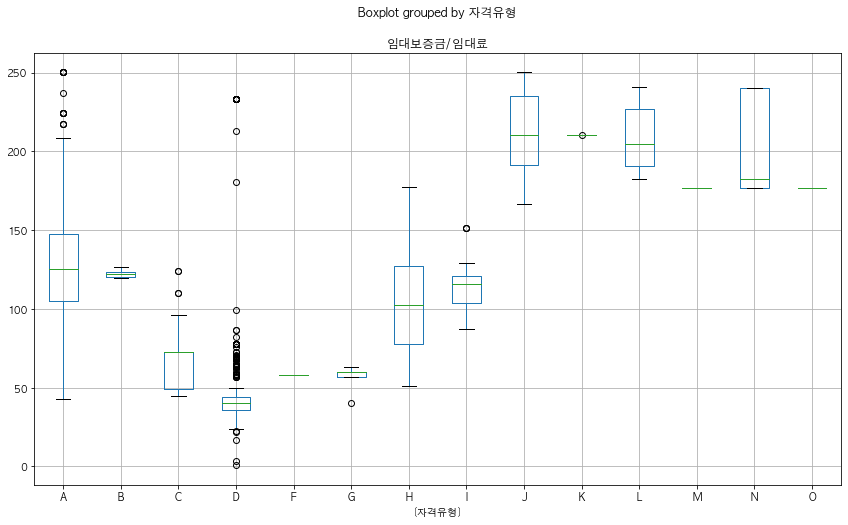

In [9]:
tmp['임대보증금/임대료'] = tmp.apply(lambda x : x['임대보증금']/x['임대료'], axis=1)
outlier_idx = get_outlier(tmp,'임대보증금/임대료')
tmp = tmp.drop(outlier_idx,axis=0)
tmp.boxplot(column=['임대보증금/임대료'],by=['자격유형'])

<AxesSubplot:title={'center':'등록차량수/주차면수'}, xlabel='[자격유형]'>

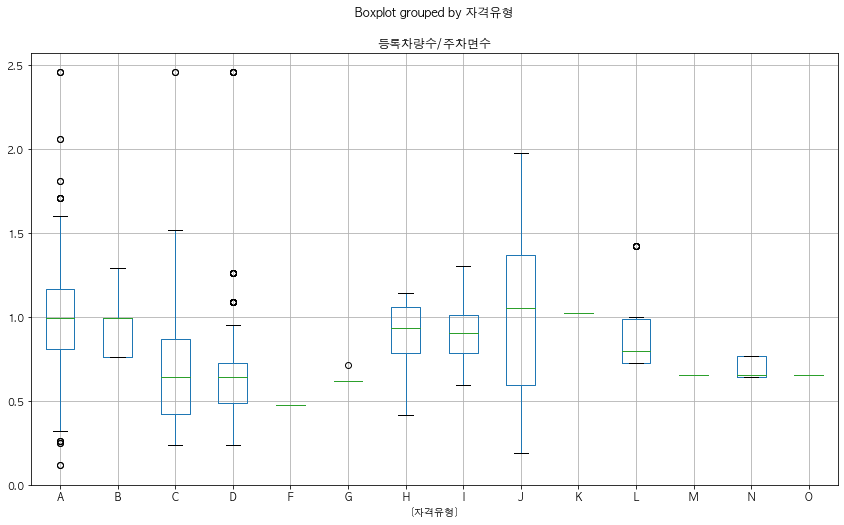

In [33]:
tmp['등록차량수/주차면수'] = tmp.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)
tmp.boxplot(column=['등록차량수/주차면수'],by=['자격유형'])

<AxesSubplot:title={'center':'등록차량수'}, xlabel='[자격유형]'>

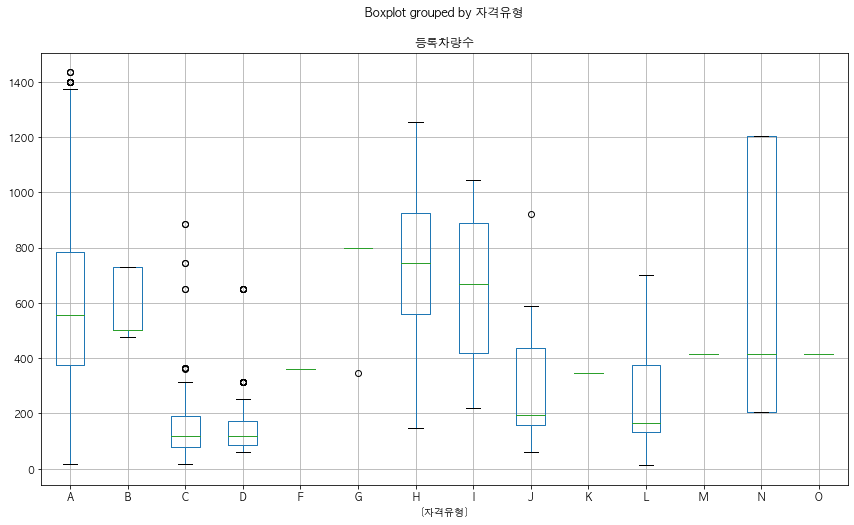

In [34]:
tmp['등록차량수/주차면수'] = tmp.apply(lambda x : x['등록차량수']/x['단지내주차면수'], axis=1)
tmp.boxplot(column=['등록차량수'],by=['자격유형'])

- C D F G 아파트 주민이 자동차 보유를 거의 하고 있지 않음(사회 취약 계층일 가능성이 높다) 임대보증금이 임대료에 비해 많이 높지 않음
- A : 가장 광범위한 그룹
- B H I : 중간 범위
- J K L M N O : 임대료에 비해 임대보증금이 엄청 큰 경우


In [10]:
train[train['임대건물구분']=='상가']['자격유형'].unique()

array(['D'], dtype=object)

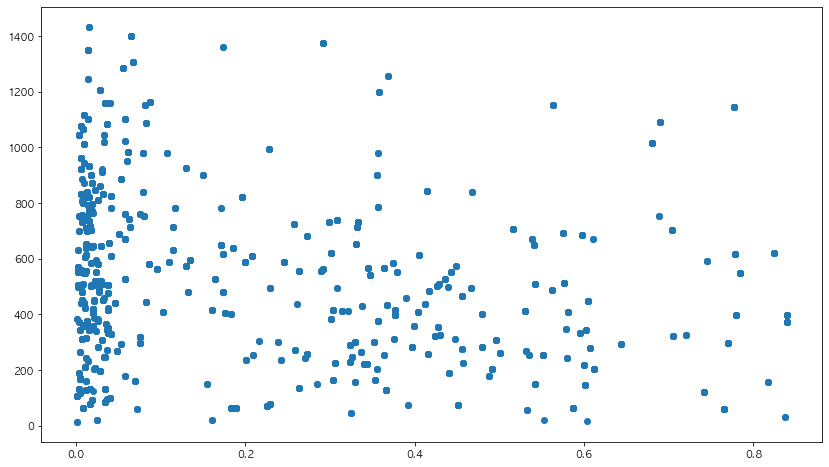

In [14]:
outlier_idx = get_outlier(tmp,'subway_dist')
tmp = tmp.drop(outlier_idx,axis=0)
plt.scatter(x=tmp['subway_dist'],y=tmp['등록차량수'])

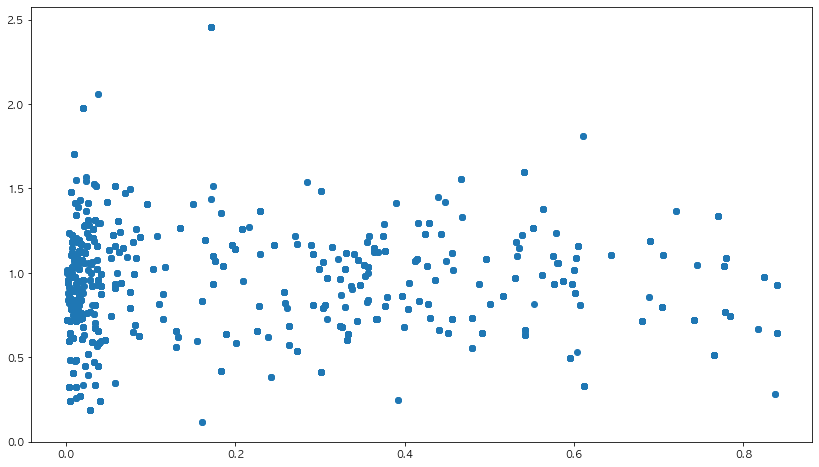

In [32]:
outlier_idx = get_outlier(tmp,'subway_dist')
tmp = tmp.drop(outlier_idx,axis=0)
plt.scatter(x=tmp['subway_dist'],y=tmp['등록차량수/주차면수'])

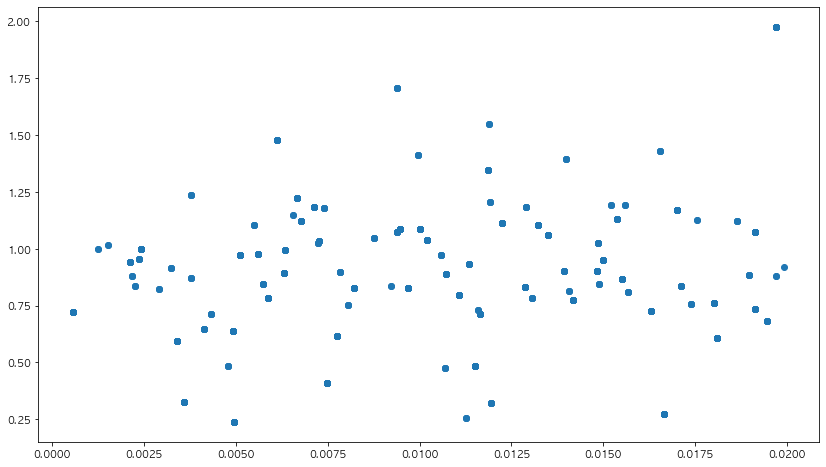

In [31]:
close = tmp[tmp['subway_dist']<0.02]
plt.scatter(x=close['subway_dist'],y=close['등록차량수/주차면수'])

<AxesSubplot:title={'center':'등록차량수/주차면수'}, xlabel='[환승역 수]'>

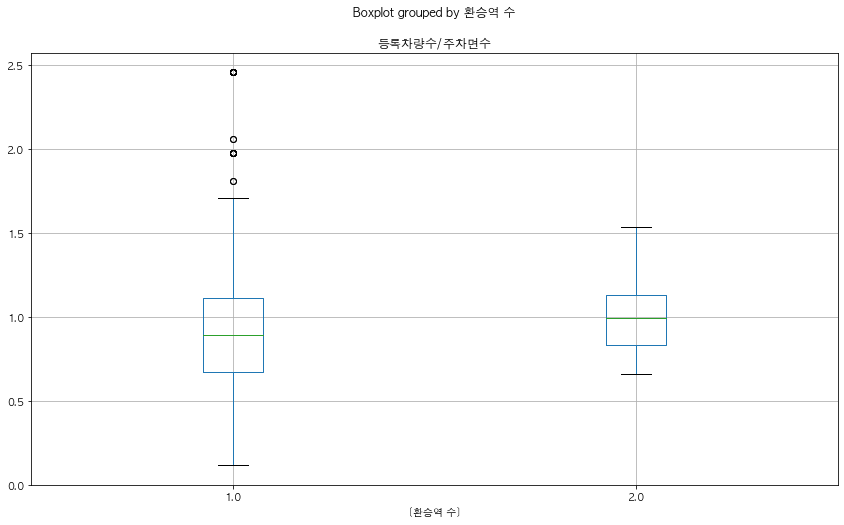

In [30]:
tmp.boxplot(column=['등록차량수/주차면수'],by=['환승역 수'])

In [29]:
tmp['등록차량수/주차면수']

0      0.7123
1      0.7123
2      0.7123
3      0.7123
4      0.7123
        ...  
2947   0.9538
2948   0.9538
2949   0.9538
2950   0.9538
2951   0.9538
Name: 등록차량수/주차면수, Length: 2316, dtype: float64